In [1]:
import numpy as np
from numpy import inf
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap
import scipy
from scipy import io
import glob
import SAplotter
from SAplotter import *
from filedata import *
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
import astropy.wcs as WCS

In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use('default')
plt.style.use(astropy_mpl_style)

In [3]:
def pixelate(ra_zoom, dec_zoom, n_bins, ra_total, dec_total, flux_total):
    import numpy as np
    # Check to see which dimension is larger so that a square in ra,dec can
    # be returned
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    # Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1] - zoom[0]) / n_bins

    # Create arrays for ra and dec that give the left side of each pixel
    spacing_dec = ((ra_zoom[1] - ra_zoom[0]) - (dec_zoom[1] - dec_zoom[0])) / 2.
    spacing_ra = ((dec_zoom[1] - dec_zoom[0]) - (ra_zoom[1] - ra_zoom[0])) / 2.

    ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0]
    dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0]
    '''
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        dec_bin_array = (np.array(range(n_bins)) * binsize) + \
            dec_zoom[0] - spacing_dec
    if (ra_zoom[1] - ra_zoom[0]) < (dec_zoom[1] - dec_zoom[0]):
        ra_bin_array = (np.array(range(n_bins)) * binsize) + \
            ra_zoom[0] - spacing_ra
    '''
    # Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array), len(dec_bin_array)))

    # Histogram components into ra bins
    ra_histogram = np.digitize(ra_total, ra_bin_array)
    # print ra_histogram

    # Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array)):
        # print range(len(ra_bin_array) -2
        # print "bin_i",bin_i
        # Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)
        # print "rainds", ra_inds[0]
        # print "lenrainds", len(ra_inds[0])

        # Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds[0]) == 0:
            continue

        # Histogram components that fall into the current ra bin slice by dec
        # print "dectotindex", dec_total[ra_inds]
        # print "decbin", dec_bin_array
        dec_histogram = np.digitize(dec_total[ra_inds], dec_bin_array)
        # print "dechist",dec_histogram
        # Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array)):

            # Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            # Go to next for cycle if no indices fall into current dec bin
            if len(dec_inds[0]) == 0:
                continue
            # Sum the flux components that fall into current ra/dec bin
            # print "bi",bin_i,bin_j
            # print "inds",ra_inds, dec_inds
            pixels[bin_i, bin_j] = np.sum(flux_total[ra_inds[0][dec_inds][0]])

    # Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = (np.arange(n_bins) * binsize) + \
        ra_zoom[0] + binsize / 2.
    dec_pixel_centers = (np.arange(n_bins) * binsize) + \
        dec_zoom[0] + binsize / 2.

    return pixels, ra_pixel_centers, dec_pixel_centers, spacing_ra, spacing_dec

In [4]:
def fits_gethduaxis(HDU, axis, strict_fits=True):
    """
    Helper function for making axis arrays for fits files.
    Args:
        HDU: a fits HDU
        axis: the axis number of interest
        strict_fits: boolean
            If True, require that the axis has cooresponding NAXIS, CRVAL,
            CDELT and CRPIX keywords. If False, allow CRPIX to be missing and
            set it equal to zero (as a way of supporting old calfits files).
            Default is False.
    Returns:
        numpy array of values for that axis
    """

    ax = str(axis)
    N = HDU.header['NAXIS' + ax]
    X0 = HDU.header['CRVAL' + ax]
    dX = HDU.header['CDELT' + ax]
    # add this for calfits backwards compatibility when the CRPIX values were often assumed to be 0
    
    try:
        Xi0 = HDU.header['CRPIX' + ax] - 1
    except(KeyError):
        if not strict_fits:
            import calfits
            calfits._warn_oldcalfits('This file')
            Xi0 = 0
        else:
            raise
    
    return dX * (np.arange(N) - Xi0) + X0

In [5]:
hdu_list = fits.open('624_TGSSfits/ds9_28505.fits')

In [19]:
hdu_list.info()

Filename: 624_TGSSfits/624_28505.FITS
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      58   (295, 288, 1, 1)   float32   


In [173]:
hdu_list[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 /                                                
NAXIS1  =                  295                                                  
NAXIS2  =                  288                                                  
BLOCKED =                    T /Tape may be blocked                             
OBJECT  = 'R17D11  '           /Source name                                     
TELESCOP= 'GMRT    '           /                                                
INSTRUME= '153MHZ  '           /                                                
OBSERVER= 'TGSS    '           /                                                
DATE-OBS= '2016-03-15'         /Obs start date YYYY-MM-DD                       
DATE-MAP= '2016-03-15'         /Last processing date YYYY-MM-DD                 
BUNIT   = 'JY/BEAM '        

In [28]:
ra_vec = fits_gethduaxis(hdu_list[0],1)
dec_vec = fits_gethduaxis(hdu_list[0],2)
print dec_vec.ndim
print ra_vec.shape

1
(295,)


In [78]:
image_data = hdu_list[0].data
print image_data.shape

(288, 295)


In [30]:
picture = fits.ImageHDU(image_data,hdu_list[0].header)

In [79]:
ra_dec = np.meshgrid(ra_vec,dec_vec,indexing='ij')

In [93]:
fig = plt.figure()
plt.imshow(image_data)
#fig.add_axes(min(ra_vec),max(ra_vec),min(dec_vec),max(dec_vec))
plt.plot(ra_vec,dec_vec)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (295,) and (288,)

In [32]:
ra_dec = np.array(ra_dec)

In [33]:
len(image_data[0])

295

In [373]:
import astropy.wcs as wcs
w = wcs.WCS(hdu_list[0],1)
ra, dec = w.all_pix2world(ra_vec,dec_vec,1)

TypeError: WCS projection has 4 dimensions, so expected 2 (an Nx4 array and the origin argument) or 5 arguments (the position in each dimension, and the origin argument). Instead, 3 arguments were given.

In [27]:
plt.imshow(ra_dec[0],ra_dec[1])

#I chose the tick marks based on the histogram above
#cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
#cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

plt.show()

NameError: name 'ra_dec' is not defined

In [35]:
plt.imshow(picture, vmin=-2.e-5, vmax=2.e-4, origin='lower')
plt.show

TypeError: Image data can not convert to float

In [24]:
#ra_zoom = [max(ra_vec),min(ra_vec)]
#dec_zoom = [max(dec_vec),min(dec_vec)]
#n_bins = 30

In [ ]:
pixels, ra_pixel_centers, dec_pixel_centers, spacing_ra, spacing_dec = \
    pixelate(ra_zoom, dec_zoom, n_bins, ra_vec, dec_vec, )

In [ ]:
#############################################################
#I found a thing to make these plots more easily! lets give it a shot

In [15]:
import wcsaxes
from wcsaxes import WCS

In [36]:
wcs = WCS(image_data)
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)

fig = plt.figure()
#ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=mywcs)
fig.add_axes(ax)  # note that the axes have to be added to the figure
ax.imshow(image_data, origin='lower')

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [7]:
import aplpy

In [53]:
from wcsaxes import datasets
from astropy.wcs import WCS

In [54]:
hdu = fits.open('624_TGSSfits/ds9_28505.fits')[0]
wcs = WCS(hdu.header)

In [75]:
wcs.sub('longitude')

TypeError: axes must None, a sequence or an integer

In [89]:
from wcsaxes import WCSAxes
fig = plt.figure()
#ax = fig.add_axes([1,1,1,1],projection=wcs)
ax = WCSAxes(wcs)
#fig.add_axes(ax)
plt.show()

TypeError: __init__() takes at least 3 arguments (2 given)

In [86]:
plt.subplot(1, 1, 1, projection=wcs)
plt.imshow(image_data)

ValueError: When providing two arguments, the array must be of shape (N, 4)

ValueError: Cannot downsample a WCS with indexing.  Use wcs.sub or wcs.dropaxis if you want to remove axes.

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmax to  3.285e-01 [aplpy.core]


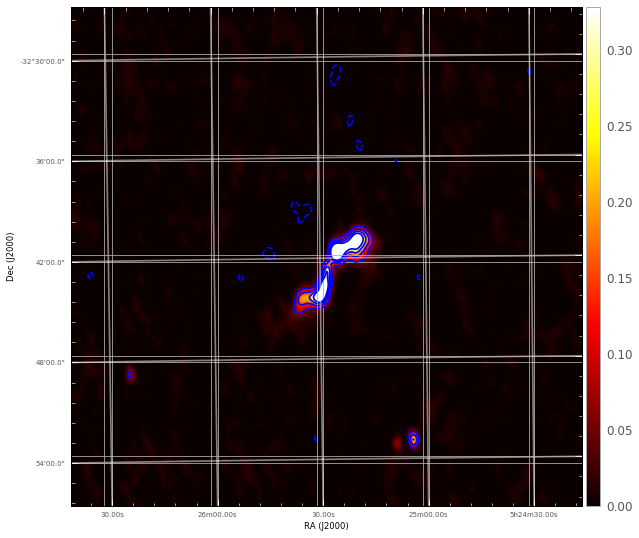

In [140]:
f = aplpy.FITSFigure('624_TGSSfits/624_28505.FITS',dimensions=(0,1))
f.show_colorscale(cmap='hot',vmin=0)
f.show_contour(colors='blue')
f.add_grid()
f.add_colorbar()
f.set_nan_color('black')
f.tick_labels.set_font(size='xx-small')
f.axis_labels.set_font(size='x-small')
plt.show()